Nemat Aloush - J42332c


In [1]:
! pip install deap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 139 kB 5.3 MB/s 


In [30]:
import math
import random
from time import time
from typing import List, Tuple, Callable, TypeVar

import deap
import matplotlib.pyplot as pyplot
import numpy
import pandas
from IPython.display import display
from deap import algorithms, base, creator, tools

random.seed(43)



The positions of queens are represented as n-element array where each queen's position p ranges p∈[0,n^2), derived from p=n×row+column.


In [ ]:
N_queens=8

In [32]:
# Fitness
# The fitness evaluation function is a count of the number of distinct queen pairs that are threatening each other; 
# thus, the problem is to minimize the fitness of individuals.
# a fitness evaluation function for an individual's genetic encoding

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

T = TypeVar('T')
def evolution(*,
      individual_generator: Callable[[], T],
      fitness_evaluation: Callable[[T], float],
      population_size: int,
      generations: int,
      crossover_rate: float,
      mutation_rate: float,
      mutation_function: Tuple[Callable, dict],
):
    # set parameters for for genetic algorithm

    start_time = time()
    toolbox = base.Toolbox()

    toolbox.register("individual", tools.initIterate, creator.Individual, individual_generator)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # fitness evaluation function
    toolbox.register("evaluate", lambda individual: (fitness_evaluation(individual),))

    # mutators 
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", mutation_function[0], **mutation_function[1])

    # selection function
    toolbox.register("select", tools.selTournament, tournsize=4)

    # generation statistics logging
    stats = tools.Statistics(key=lambda individual: individual.fitness.values)
    stats.register("min", lambda population: numpy.min([fitness for fitness in population if fitness[0] != math.inf]))
    stats.register("avg", lambda population: numpy.mean([fitness for fitness in population if fitness[0] != math.inf]))
    stats.register("max", lambda population: numpy.max([fitness for fitness in population if fitness[0] != math.inf]))

    # fittest individual with a hall of fame record
    hall_of_fame = tools.HallOfFame(maxsize=1)

    # run genetic algorithm
    _, log = algorithms.eaSimple(
        toolbox.population(n=population_size),
        toolbox,
        ngen=generations,
        cxpb=crossover_rate, mutpb=mutation_rate,
        stats=stats, halloffame=hall_of_fame, verbose=False,
    )

    # return duration, statistics log, and the fittest individual
    return time() - start_time, log, hall_of_fame[0]

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [33]:
def plot_generations(generation: List[int], average: List[float], minimum: List[int], maximum: List[int]):
    pyplot.figure(figsize=(16, 8))
    pyplot.grid(True)
    pyplot.plot(generation, average, label="average")
    pyplot.plot(generation, minimum, label="minimum")
    pyplot.plot(generation, maximum, label="maximum")
    pyplot.xlabel("Generation")
    pyplot.ylabel("Fitness")
    pyplot.ylim(-1)
    pyplot.legend(loc="upper right")
    pyplot.show()

In [35]:
def evaluate(individual: List[int]) -> float:
    #  removed duplicate values 
    if len(individual) != len(set(individual)):
        return math.inf

    dimension = len(individual)
    # count all pairs of conflicts
    fitness: float = 0
    for x in range(len(individual)):
        x_row, x_column = individual[x] // dimension, individual[x] % dimension
        for y in range(x + 1, len(individual)):
            y_row, y_column = individual[y] // dimension, individual[y] % dimension
            if x_row == y_row or x_column == y_column or abs(x_row - y_row) == abs(x_column - y_column):
                fitness += 1
    return fitness

Computed in 16.544 seconds


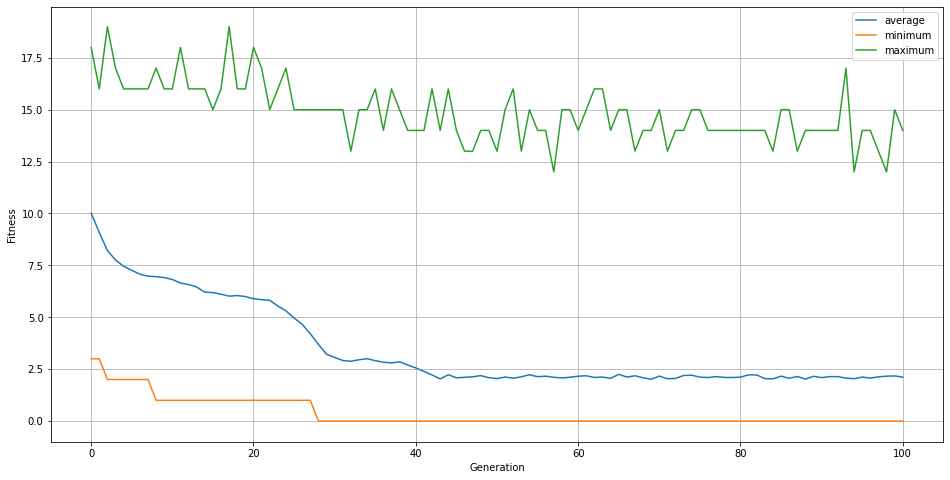

In [38]:
duration, log, fittest_individual = evolution(
    individual_generator=lambda: random.choices(range(N_queens**2), k=N_queens),
    fitness_evaluation=evaluate,
    population_size=2500,
    generations=100,
    crossover_rate=.5,
    mutation_rate=.5,
    mutation_function=(tools.mutUniformInt, {"low": 0, "up": 8**2 - 1, "indpb": 1/4})
)
print(f"Computed in {duration:.3f} seconds")
plot_generations(*log.select("gen", "avg", "min", "max"))

In [34]:
def display_grid(individual: List[int]):
    dimension = len(individual)

    board = pandas.DataFrame("", index = range(1, dimension + 1), columns = range(1, dimension + 1))

    # draw conflicts with a red line
    for x in range(dimension):
        x_row, x_column = individual[x] // dimension, individual[x] % dimension
        for y in range(x + 1, dimension):
            y_row, y_column = individual[y] // dimension, individual[y] % dimension

            diff_row, diff_column = y_row - x_row, y_column - x_column
            if x_row == y_row or x_column == y_column or abs(diff_row) == abs(diff_column):
                for i in range(1 + max(abs(diff_row), abs(diff_column))):
                    board[1 + x_column + i * numpy.sign(diff_column)][1 + x_row + i * numpy.sign(diff_row)] = "🟥"

    # draw all queens
    for queen in individual:
        row, column = queen // dimension, queen % dimension
        board[1 + column][1 + row] = "👑" if board[1 + column][1 + row] == "" else "♕"

    display(board)

In [39]:
print(f"Positions: {fittest_individual}")
print(f"Duplicate queens: {len(fittest_individual) - len(set(fittest_individual))}")
print(f"Fitness: {abs(fittest_individual.fitness.values[0])}")
display_grid(fittest_individual)

Positions: [15, 5, 32, 27, 17, 58, 52, 46]
Duplicate queens: 0
Fitness: 0.0


,1,2,3,4,5,6,7,8
1,,,,,,👑,,
2,,,,,,,,👑
3,,👑,,,,,,
4,,,,👑,,,,
5,👑,,,,,,,
6,,,,,,,👑,
7,,,,,👑,,,
8,,,👑,,,,,
